In [ ]:
import sys
!{sys.executable} -m pip3 install pandas
!{sys.executable} -m pip3 install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install openpyxl

#### import libraries

In [8]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import math
pandas.options.mode.chained_assignment = None

### Part A: fill missing values and preprocessing

In [173]:
CSM_dataset = pandas.read_excel('CSM_dataset.xlsx', engine='openpyxl',)
CSM_dataset = CSM_dataset.select_dtypes(include='number')  # use only numeric columns
print(CSM_dataset.shape)
CSM_dataset.head()

(232, 13)


,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,2014.0,6.3,8.0,9130.0,4000000.0,45.0,1.0,0.0,3280543.0,4632.0,425.0,636.0,1120000.0
1,2014.0,7.1,1.0,192000000.0,50000000.0,3306.0,2.0,2.0,583289.0,3465.0,61.0,186.0,12350000.0
2,2014.0,6.2,1.0,30700000.0,28000000.0,2872.0,1.0,0.0,304861.0,328.0,34.0,47.0,483000.0
3,2014.0,6.3,1.0,106000000.0,110000000.0,3470.0,2.0,0.0,452917.0,2429.0,132.0,590.0,568000.0
4,2014.0,4.7,8.0,17300000.0,3500000.0,2310.0,2.0,0.0,3145573.0,12163.0,610.0,1082.0,1923800.0


##### fill missing valuse: replacing nan value by mean of that column

In [174]:
for col in CSM_dataset.columns:
    mean_value=CSM_dataset[col].mean()
    CSM_dataset[col].fillna(value=mean_value, inplace=True)
print("number of nan row in new dataset: " + str(CSM_dataset.shape[0] - CSM_dataset.dropna().shape[0]))

number of nan row in new dataset: 0


##### preprocessing: scaling all data by Z-score normalization and split data and labels

In [176]:
CSM_dataset = CSM_dataset.sample(frac=1).reset_index(drop=True)  # shuffeling data
labels = CSM_dataset['Ratings']
data = CSM_dataset.drop(columns="Ratings")
for col in data.columns:
#     data[col]=(data[col]-data[col].mean())/data[col].std()  ## z-score normalization
    data[col]=(data[col]-data[col].min())/(data[col].max()-data[col].min())  ## min-max normalization
data.head()

,Year,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,0.0,0.000000,0.000197,0.099748,0.006016,0.0,0.537313,0.008865,0.000383,0.001218,0.000235,0.097880
1,0.0,0.357143,0.009296,0.055736,0.425497,0.0,0.597015,0.011659,0.000640,0.001934,0.001121,0.000436
2,0.0,0.500000,0.059872,0.159765,0.708006,0.0,0.567164,0.084502,0.008174,0.029943,0.006543,0.145668
3,0.0,0.500000,0.040432,0.031729,0.649468,0.0,0.567164,0.187943,0.039233,0.046777,0.022052,0.379708
4,0.0,0.142857,0.078535,0.043732,0.293845,0.0,0.776119,0.282665,0.112608,0.066189,0.094075,0.057976


### Part B: plot correlation matrix of features

In [177]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Year,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
Year,1.00,-0.03,0.12,0.10,0.25,0.10,0.23,0.21,0.08,0.23,0.04,-0.03
Genre,-0.03,1.00,-0.20,-0.26,-0.14,-0.22,-0.01,-0.03,-0.04,-0.03,-0.10,0.01
Gross,0.12,-0.20,1.00,0.72,0.58,0.42,-0.02,0.18,0.11,0.16,0.13,0.29
Budget,0.10,-0.26,0.72,1.00,0.59,0.46,0.03,0.11,0.01,0.10,0.09,0.16
Screens,0.25,-0.14,0.58,0.59,1.00,0.27,-0.02,0.25,0.16,0.26,0.19,0.19
Sequel,0.10,-0.22,0.42,0.46,0.27,1.00,-0.11,-0.04,-0.04,-0.06,-0.07,0.23
Sentiment,0.23,-0.01,-0.02,0.03,-0.02,-0.11,1.00,0.06,0.05,0.04,0.06,-0.09
Views,0.21,-0.03,0.18,0.11,0.25,-0.04,0.06,1.00,0.68,0.78,0.71,0.15
Likes,0.08,-0.04,0.11,0.01,0.16,-0.04,0.05,0.68,1.00,0.47,0.92,0.08
Dislikes,0.23,-0.03,0.16,0.10,0.26,-0.06,0.04,0.78,0.47,1.00,0.58,0.05


### Part C: remove redundant features

In [194]:
correlated_features = []
for row in data.columns:
    for col in data.columns:
        if row != col and corr[row][col] > 0.7:
            if (col, row) not in correlated_features:
                correlated_features.append((row, col))
            
redundant_features = []
for feature in list(correlated_features):
    if feature[0] not in redundant_features:
        redundant_features.append(feature[0])
print('redundant features: ' + str(redundant_features))
data_selected = data
for feature in redundant_features:
    data_selected = data_selected.drop(columns=feature)
data_selected.head()
# corr_data_selected = data_selected.corr()
# corr_data_selected.style.background_gradient(cmap='coolwarm').set_precision(2)

redundant features: ['Gross', 'Views', 'Likes']


,Year,Genre,Budget,Screens,Sequel,Sentiment,Dislikes,Comments,Aggregate Followers
0,0.0,0.000000,0.099748,0.006016,0.0,0.537313,0.001218,0.000235,0.097880
1,0.0,0.357143,0.055736,0.425497,0.0,0.597015,0.001934,0.001121,0.000436
2,0.0,0.500000,0.159765,0.708006,0.0,0.567164,0.029943,0.006543,0.145668
3,0.0,0.500000,0.031729,0.649468,0.0,0.567164,0.046777,0.022052,0.379708
4,0.0,0.142857,0.043732,0.293845,0.0,0.776119,0.066189,0.094075,0.057976


### Part D: gradient descent algorithem

In [195]:
def create_multi_degree_data(data, degree):
    # Regression part: get data and degree and create matrix of data with from 1 to that degree
    new_data = [[1 for _ in range(data.shape[0])],]
    for j in range(data.shape[1]):
        for i in range(1, degree+1):
            new_data.append(data[:,j] ** i)
    new_data = np.array(new_data).T
    return new_data 

In [196]:
def data_to_matrix(data, label, degree):
    # Regression part: convert data and label to numpy matrix
    data = data.to_numpy()
    data = create_multi_degree_data(data, degree)
    label = label.to_numpy()
    label = label.reshape((label.shape[0],1))
    l = int(0.8*data.shape[0])
    X_train, X_test, y_train, y_test = data[:l], data[l:], label[:l], label[l:]
    return X_train, X_test, y_train, y_test

In [197]:
def calculate_new_weights(X, y, weights, lr):
    # Regression part: Calculate new weights for this step
    gradian = (X.T @ X @ weights) - (X.T @ y)
    gradian = gradian / np.linalg.norm(gradian)
    new_weights = weights - (lr * gradian)
    return new_weights

In [198]:
def calculate_error(X, y, weights, error_type):
    # Regression part: Calculate error in three types of error
    if error_type == 'MSE':
        error = np.square((X @ weights) - y).mean()
    elif error_type == 'RMSE':
        error = (np.square((X @ weights) - y).mean())**0.5
    elif error_type == 'MAE':
        error = np.abs((X @ weights) - y).mean()
    else:
        print('error type must be one of "MSE", "RMSE", "MAE"')
    return error

In [199]:
def gradient_descent(X_train, X_test, y_train, y_test, weights, lr, number_of_steps, error_type):
    # Regression part: Do gradian descent algorithm
    train_errors = []
    test_errors = []
    lrs = []
    for i in range(number_of_steps):
        # Save errors and lr to plot at the end of algorithem
        lrs.append(lr)
        train_error = calculate_error(X_train, y_train, weights, error_type)
        train_errors.append(train_error)
        test_error = calculate_error(X_test, y_test, weights, error_type)
        test_errors.append(test_error)
#         print('---step ' + str(i) + '------ error: ' + str(train_error))
        
        weights = calculate_new_weights(X_train, y_train, weights, lr)
        lr = 10/(i+1) # Change leaning rate
        if train_error < 0.001:
            print('error is less than 0.001')
            break
    return weights, train_errors, test_errors, lrs

In [200]:
def run_algorithem(data, label, degree, number_of_steps, error_type):
    # Regression part: run gradian descen algorithm and return best weitghts and errors
    X_train, X_test, y_train, y_test = data_to_matrix(data, label, degree)
    weights = np.full((X_train.shape[1], 1), 0.1)
    lr = 10  # learning rate
    best_weights, train_errors, test_errors, lrs = gradient_descent(X_train, X_test, y_train, y_test, weights, lr, number_of_steps, error_type)
    print('error in train data:' + str(calculate_error(X_train, y_train, best_weights, error_type)))
    print('error in test data:' + str(calculate_error(X_test, y_test, best_weights, error_type)))
    return best_weights, train_errors, test_errors, lrs

In [201]:
def plot_errors(train_errors, test_errors, title):
    # Plot errors or training and testing data per itteration
    x1 = [i for i in range(len(train_errors))]
    y1 = train_errors
    plt.plot(x1, y1, label = "train errors", )
    x2 = [i for i in range(len(test_errors))]
    y2 = test_errors
    plt.plot(x2, y2, label = "test errors", )
    plt.title(title)
    plt.legend()
    plt.show()

def plot_lrs(lrs):
    x3 = [i for i in range(len(lrs))]
    y3 = lrs
    plt.plot(x3, y3, label = "learnin rate")
    plt.legend()
    plt.yticks(np.arange(0, 10, 2))
    plt.show()

##### Run algorithm with all data and plot errors and lr using above functions

error in train data:0.6731100074008364
error in test data:0.7995064731516077


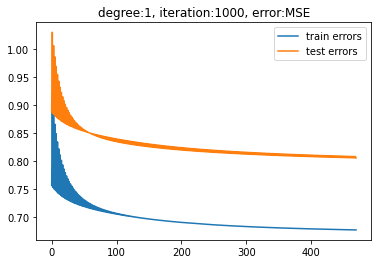

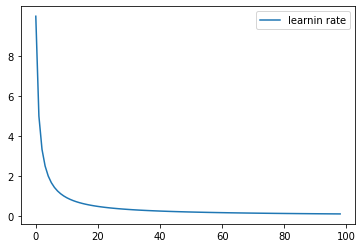

In [202]:
degree = 1
epochs = 1000
error_type = 'MSE'
coefficients, train_errors, test_errors, lrs = run_algorithem(data, labels, degree, epochs, error_type)

title = 'degree:' + str(degree) + ', iteration:' + str(epochs) + ', error:' + str(error_type)
plot_errors(train_errors[30:500], test_errors[30:500], title)
plot_lrs(lrs[1:100])

##### Run algorithm with selected data and plot errors and lr using above functions

error in train data:0.7658584425745919
error in test data:0.9525931152846092


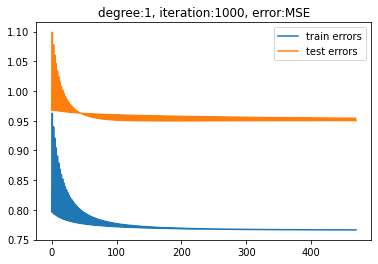

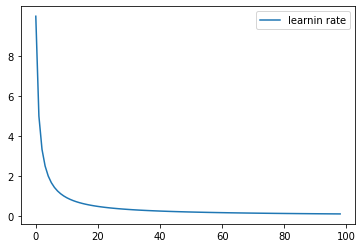

In [208]:
degree = 1
epochs = 1000
error_type = 'MSE'
coefficients, train_errors, test_errors, lrs = run_algorithem(data_selected, labels, degree, epochs, error_type)

title = 'degree:' + str(degree) + ', iteration:' + str(epochs) + ', error:' + str(error_type)
plot_errors(train_errors[30:500], test_errors[30:500], title)
plot_lrs(lrs[1:100])